<a href="https://colab.research.google.com/github/TAUforPython/wavelets/blob/main/wavelets_cwt_dwt_example_EEG_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Code Overview

**Учебный ноутбу**к - обработка простых математических и медицинских данных ЭЭГ и ЭКГ


Примеры научных статей о применении wavelet в биоинформатике:
Грубов В. В., Овчинников А. А., Ситникова Е. Ю., Короновский А. А., Храмов А. Е. Вейвлетный анализ сонных веретен на ЭЭГ и разработка метода их автоматической диагностики // Известия вузов. ПНД. 2011. Т. 19, вып. 4. С. 91-108. DOI: 10.18500/0869-6632-2011-19-4-91-108
[ссылка на статью](https://andjournal.sgu.ru/ru/articles/veyvletnyy-analiz-sonnyh-vereten-na-eeg-i-razrabotka-metoda-ih-avtomaticheskoy-diagnostiki)

[Ссылка](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/) на примеры кода как использовать Wavelet:

Полезные ссылки на литературу:

https://habr.com/ru/articles/460445/

https://www.scicoding.com/introduction-to-wavelet-transform-using-python/



In [ ]:
# устанавливаем библиотеку для загрузки зависимостей
# для обработки данных с помощью вейвлетов
!pip install pywavelets mne --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.3 MB/s eta 0:00:00


In [ ]:
# подгружаем библиотеки
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne

In [ ]:
# фильтр Баттерфорда для вырезания полосы частот
from scipy import signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

In [ ]:
# функция преобразования Гильберта для построения огибающей
from scipy.fft import fft, ifft
def my_func_hilbert(x):
    N = len(x)
    xf = fft(x)
    xf[1:N//2] *= 2
    if N % 2 == 1:
        xf[N//2] *= 2
    xf[N//2 + 1:] = 0
    xa = ifft(xf)
    assert np.allclose(xa.real, x)
    return xa

In [ ]:
# модули для обработки временных рядов (убрать тренд и аппроксимировать)
class Detrending:
  def plot(t,y,slope,intercept):
    fig = plt.figure(figsize=(10,7))
    ax = plt.subplot(111)
    plt.scatter(t,y, s=5)
    plt.plot(t, slope*t + intercept, 'r',
             label='y={:.2f}x+{:.2f}'.format(slope,intercept))
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlabel('time')
    plt.ylabel('Y')
    plt.show()

  def line_fit(t,y):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
    #line = slope*t + intercept
    return slope, intercept

  def trend_off(t,y):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
    line = slope*t + intercept

    y_nontrend = y-line
    return y_nontrend


# **Теория** - виды материнского вейвлета (ядро преобразования)

In [ ]:
for family in pywt.families():
    print(f'{family} family: {pywt.wavelist(family)}')

haar family: ['haar']
db family: ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38']
sym family: ['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
coif family: ['coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17']
bior family: ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8']
rbio family: ['rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3

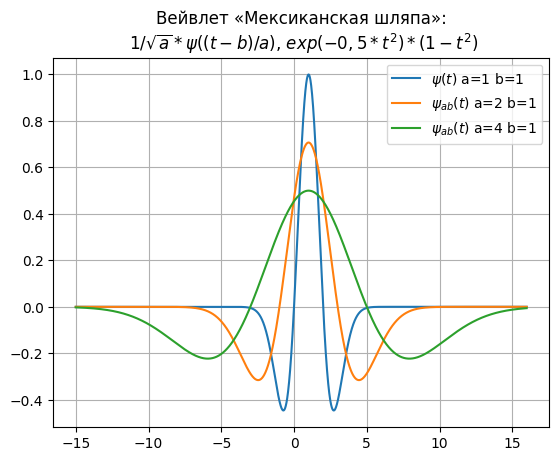

In [ ]:
x = np.arange(-15,16,0.01)
def w(a,b,t):
    f =(1/a**0.5) * np.exp(-0.5*((t-b)/a)**2) * (1 - ((t-b)/a)**2)
    return f
plt.title("Вейвлет «Мексиканская шляпа»:\n $1/\sqrt{a}*\psi({(t-b)}/{a})$, $exp(-0,5*t^{2})*(1 - t^{2})$")

b = 1
y=[w(1,b,t) for t in x]
plt.plot(x,y, label = '$\psi(t)$ a=1 b=1')
y=[w(2,b,t) for t in x]
plt.plot(x,y,label="$\psi_{ab}(t)$ a=2 b=1")
y=[w(4,b,t) for t in x]
plt.plot(x,y,label="$\psi_{ab}(t)$ a=4 b=1")
plt.legend(loc='best')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Morle')

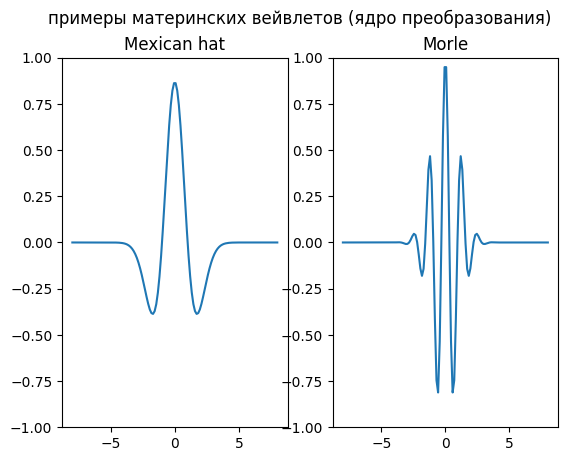

In [ ]:
#discrete wavelet
#wavelet_d = pywt.Wavelet('db5')
#[phi, psi, x] = wavelet_d.wavefun(level=1)
#continous wavelet
# The wavefun() method can be used to calculate approximations of scaling function (phi) and wavelet function (psi) at the given level of refinement.
wavelet_c = pywt.ContinuousWavelet('mexh')
[psi,x] = wavelet_c.wavefun(level = 7)
wavelet_c = pywt.ContinuousWavelet('morl')
[psi_morle,x] = wavelet_c.wavefun(level = 7)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('примеры материнских вейвлетов (ядро преобразования) ')

ax1.plot(x, psi)
ax1.set_ylim(-1, 1)
ax1.set_title("Mexican hat")
#Вейвлет «Мексиканская шляпа»:\n$1/\sqrt{a}*exp(-0,5*t^{2}/a^{2})*(t^{2}-1)$")

ax2.plot(x, psi_morle)
ax2.set_ylim(-1, 1)
ax2.set_title("Morle")

pywt.families() = ['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
pywt.wavelist('db') = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38']
len(x) = 225


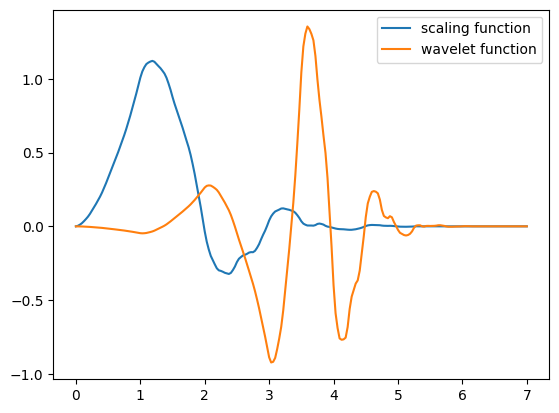

In [ ]:
#### visualize (mother) wavelet and scaling (father wavelet) functions
print('pywt.families() = %s' % pywt.families())
print('pywt.wavelist(\'db\') = %s' % pywt.wavelist('db'))
phi, psi, x = pywt.Wavelet('db4').wavefun(level=5) # level of refinement
print('len(x) = %s' % len(x))

plt.figure()
plt.plot(x,phi,label='scaling function')
plt.plot(x,psi,label='wavelet function')
plt.legend()

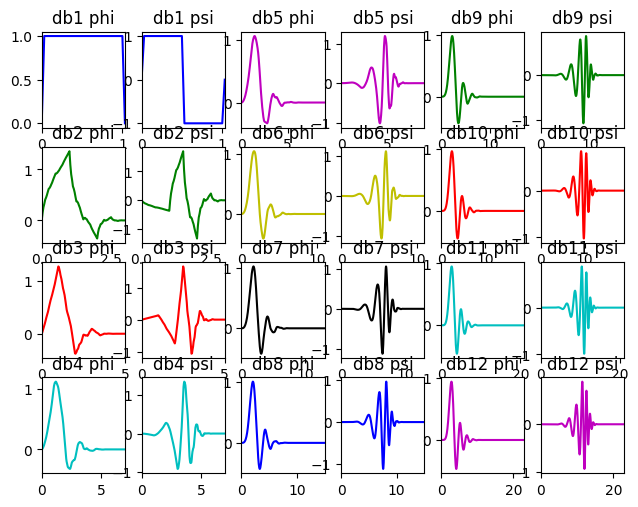

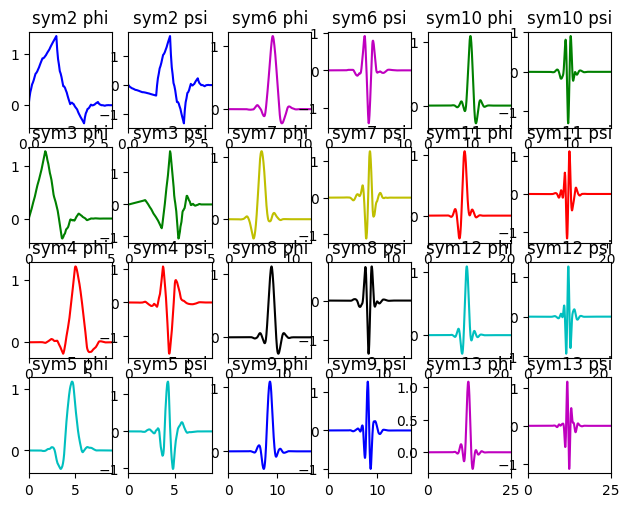

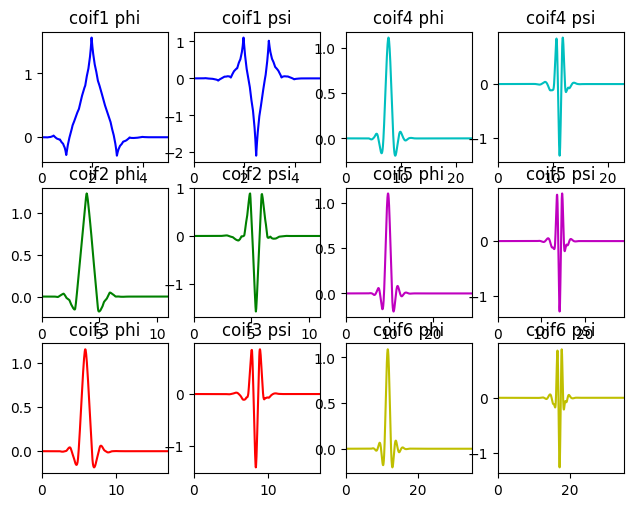

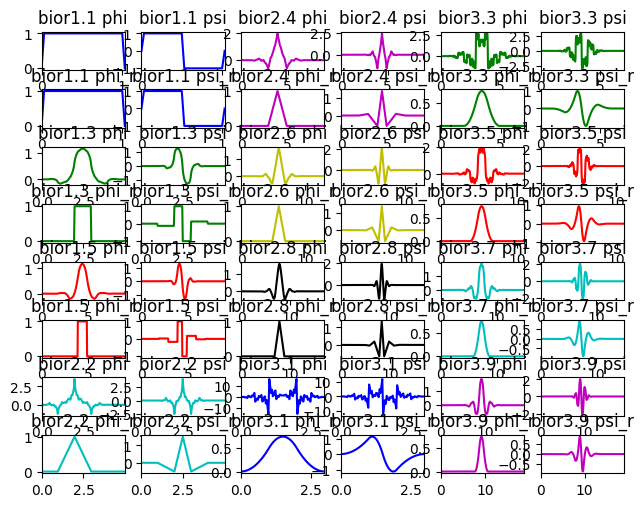

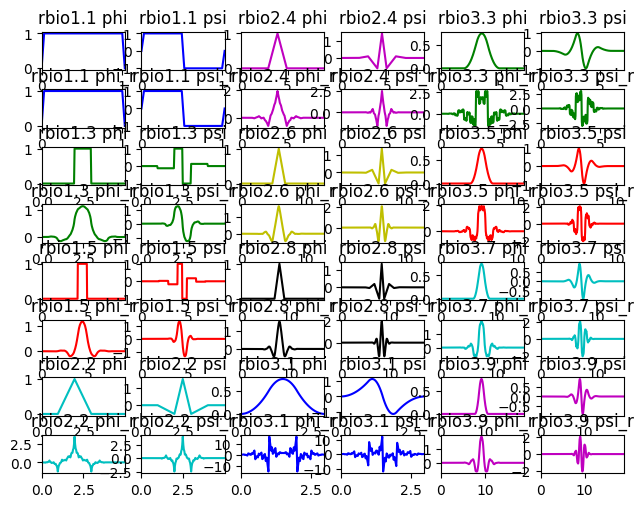

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Plot scaling and wavelet functions for db, sym, coif, bior and rbio families

import itertools

import matplotlib.pyplot as plt

import pywt


plot_data = [('db', (4, 3)),
             ('sym', (4, 3)),
             ('coif', (3, 2))]


for family, (rows, cols) in plot_data:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)
    colors = itertools.cycle('bgrcmyk')

    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, x = wavelet.wavefun(level=5)

            color = next(colors)
            ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)

    colors = itertools.cycle('bgrcmyk')
    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
            row *= 2

            color = next(colors)
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

            row += 1
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi_r")
            ax.plot(x, phi_r, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi_r")
            ax.plot(x, psi_r, color)
            ax.set_xlim(min(x), max(x))

plt.show()

# **Практика** - простые математические сигналы

**запускай что-то одно** - тут примеры разные как исопльзовать Python Google Colab для рабты с данными

## пример №1

In [ ]:
# пример загрузки данных из файла csv
# файл создается в другом google colab notebook
# и вручную переносится сюда (вот пример)
# https://colab.research.google.com/drive/1Uuh2nl5JAuqmTt4ahOwAPlTv9sEuc_Fb?usp=sharing
# в файл локальный на юпитер-ноутбуке сохраняем с именем buffervar.csv любые данные
data_from_csv = np.genfromtxt('buffervar.csv', delimiter=',')
t = np.linspace(0, 40, 2000)
# время сигнала = длительность
T = 40.0
# количество точек в сигнале = число отсчетов
N = 2000
# значения сигнала
y = data_from_csv[:, 0]

## Пример №2

In [ ]:
# пример загрузки данных из файла csv
data_from_csv = np.genfromtxt('raw_acoustic_data_aircompressor-healthy.csv', delimiter=',')
#data_from_csv = np.genfromtxt('raw_acoustic_data_aircompressor-bearing.csv', delimiter=',')

# время сигнала = длительность 5 секунд
T = 5.0

# значения сигнала
y = data_from_csv

# количество точек в сигнале = число отсчетов
N = len(y)
t = np.linspace(0, T, N)

## Пример №3

In [ ]:
# пример загрузки данных из внешнего файла csv
# загрузить курс доллара
data_usdrub = pd.read_csv("UsdRubTime.csv", sep = ';')

df_usdrub = pd.DataFrame(data_usdrub, columns = ['Close', 'Position'])

print(df_usdrub.head)
y = df_usdrub['Close'].values

T = max(df_usdrub['Position'])
N = len(df_usdrub['Position'])
t = np.linspace(1, T, N)

<bound method NDFrame.head of        Close  Position
0      0.988         1
1      0.993         8
2      1.000        15
3      1.020        22
4      1.300        29
...      ...       ...
1537  73.348     10760
1538  74.230     10767
1539  76.135     10774
1540  75.712     10781
1541  76.072     10788

[1542 rows x 2 columns]>


## Пример №4

In [ ]:
# пример трех графиков для смешивания параметров для фильтрации ICA
sampl_rate=1000
N = 2000
T = 40
t=np.linspace(0,T,N)
sfreq = 100
sine = 1*np.sin(2*np.pi*sfreq*t)
sawtooth = 1*signal.sawtooth(2*np.pi*sfreq*t)
square = 1*signal.square(2*np.pi*sfreq*t)

y_original = np.c_[sine,sawtooth,square]

weight = np.array([[0.2,0.2,0.6],[0.33,0.33,0.34],[0.6,0.2,0.2]])
y = np.dot(y_original, weight.T)

## Пример №5

In [ ]:
# ещё пример трех графиков для смешивания параметров для фильтрации ICA

N = 2000
T = 8
t=np.linspace(0,T,N)

s1 = np.sin(2 * t) * np.sin(40 * t)
s2 = np.sin(3 * t) ** 5
s3 = 0.1*np.random.laplace(size=s1.shape)

y_original = np.c_[s1, s2, s3]

weight = np.array([[0.2,0.2,0.6],[0.33,0.33,0.34],[0.6,0.2,0.2]])
y = np.dot(y_original, weight.T)

## Пример №6

In [ ]:
# пример загрузки данных из внешнего файла csv
# загрузить курс доллара
data_usdrub = pd.read_csv("UsdRubTime.csv", sep = ';')

df_usdrub = pd.DataFrame(data_usdrub, columns = ['Close', 'Position'])

print(df_usdrub.head)
y = df_usdrub['Close'].values
#y = np.sort(y)[::-1]
y = y[::-1]

T = max(df_usdrub['Position'])
N = len(df_usdrub['Position'])
#t = np.linspace(1, T, N)
t = df_usdrub['Position'].values
t = np.sort(t)

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
line = slope*t + intercept

y_nontrend = y-line

dy_nontrend_dt = np.array([0])
dy_nontrend_dt[0] = 0
for i in range(len(y)-1):
  dy_nontrend_dt = np.append(dy_nontrend_dt, (y_nontrend[i+1] - y_nontrend[i])/(t[i+1] - t[i]))
y = y_nontrend

<bound method NDFrame.head of        Close  Position
0      0.988         1
1      0.993         8
2      1.000        15
3      1.020        22
4      1.300        29
...      ...       ...
1537  73.348     10760
1538  74.230     10767
1539  76.135     10774
1540  75.712     10781
1541  76.072     10788

[1542 rows x 2 columns]>


## Пример №7

In [ ]:
# гармонический детерминированный сигнал - всего три гармоники
# число точек в выборке
N = 60*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0.0, T, N)

y = 1*np.cos(1.0 * 2.0*np.pi*t) + 1*np.cos(3 * 2.0*np.pi*t) + 1*np.cos(7.0 * 2.0*np.pi*t)

## Пример №8

In [ ]:
# затухающий гармонический сигнал

# число точек в выборке
N = 60*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0.0, T, N)
y = np.exp(-t)*np.sin(3.0 * 2.0*np.pi*t)

## Пример №9

In [ ]:
# ступенчатный детерминированный сигнал
events = [2.5, 4]
w1=0.5; w2=1;
y = 1*((t > events[0]-w1) & (t < events[0]+w1)) + \
    0* ((t > events[1]-w2) & (t < events[1]+w2))

## Пример №10

In [ ]:
# случайный сигнал
# число точек в выборке
N = 60*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0.0, T, N)
y = np.sin(3.0 * 2.0*np.pi*t) + np.random.normal(0, scale=0.5, size=len(t))


## Пример №11

In [ ]:
# гармонический сигнал с увеличением частоты

# число точек в выборке
N = 60*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0.0, T, N)
y = np.sin(2.0*np.pi * (1 + t)*t)

## Пример №12

In [ ]:
# экспонента
# число точек в выборке
N = 60*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0.0, T, N)
y = 1 - np.exp(-t) + 0*np.random.normal(0, scale=0.5, size=len(t))

## Пример №13

In [ ]:
# гармонический детерминированный модулированный сигнал
# число точек в выборке
N = 600*5
# задаем максимальное время (конечное) чуть больше чеме 2*pi, начало отсчета в нуле.
T = 5.0
t = np.linspace(0.0, T, N)

y = np.sin(1.0 * 0.5*np.pi*t) * np.cos(16.0 * 2.0*np.pi*t)

# **Практика** - медицинские данные

## Пример №1 - загрузка ЭЭГ с google drive

In [ ]:
# создайте свою папку на Google Drive, туда скачайте EDF файл
# используйте этот код для загрузки EDF
# если у Вас нет своего EDF файла - перейдите к следующему примеру

from google.colab import drive
drive.mount('/content/drive')
# путь к файлу на гугл-диске


# ECG
#edf_path = '/content/drive/MyDrive/edf_process/ECG_example.edf'
#edf_path = '/content/drive/MyDrive/edf_process/ECGrhmn_example.edf'

# EEG_21
# 20.04.2019	19:33:06	00:45:03
# Приступ на 19:45:55, ФС с 20:10:28 по 20:12:58 и с 20:13:12 по 20:15:42 (1,2,3,8,10,15,18,20,25,30,50 Гц обе)
# Приступ на 720 секунде, ФС с 2220 секунды в течение 120 секунд и с 2400 секунды на 120 секунд
#edf_path = '/content/drive/MyDrive/edf_process/EEG_21.edf'

#EEG_85
#08.02.2020	01:54:04	08:00:00
#Приступ 2:28 и 2:43 и 3:30 и 5:49 и 5:52, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) с 7:34 по 7:36, ГВ с 7:37 по 7:40
#Приступ на 2040 секунде , ФС с 20400 секунды
#edf_path = '/content/drive/MyDrive/edf_process/EEG_85.edf'

#EEG_793
#13.01.2020	16:59:34	08:00:00
#Приступа нет, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) 18:58 по 19:01, ГВ с 19:02 по 19:07
#Приступ нет, ФС с 10710 секунды
#edf_path = '/content/drive/MyDrive/edf_process/EEG_793.edf'


#EEG_95
# 23.01.2020 12:26:50 08:00:00
# приступа нет, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) с 18:41 по 18:44, ГВ с 18:45 по 19:10
#Приступ нет, ФС с 22500 секунды
#edf_path = '/content/drive/MyDrive/edf_process/EEG_95.edf'


# EEG_28
# 12.02.2020	17:36:10	08:00:00
# Приступ 22:53, ФС (1,2,3,8,10,15,18,20,25,30,50 Гц) с 23:14 по 23:17, ГВ 23:18 по 23:24
# Приступ на 19020 секунде, ФС с 20280 секунды в течение 120 секунд
#edf_path = '/content/drive/MyDrive/edf_process/EEG_28.edf'

#EEG healthy man
edf_path = '/content/drive/MyDrive/edf_process/EDF_example_FS_healthy.edf'


# загрузка файла (данные в структуре переданы в переменную)
data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)

In [ ]:
data_from_raw_edf.info

In [ ]:
# EDF - файл содержит многоканальную запись ЭЭГ
# ECG - файл содержит запись электрокардиограммы
data_from_raw_edf.plot(scalings = 'auto', show = False)
# список каналов из файла EDF
print(data_from_raw_edf.ch_names)

In [ ]:
print(data_from_raw_edf.ch_names)
print(eeg_times[-1]-eeg_times[0])

In [ ]:
eeg_times


In [ ]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
print('число отчетов во временном ряду:',len(eeg_times))
# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 0*2200 +20)[0][0]
t_index_end = np.where(eeg_times > 0*2200 + 180)[0][0]
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

# удалаем ненужные сигналы из массива данных ЭЭГ
# в случае сигнала EEG_21 8 канал 'Value MKR+-MKR-'
eeg_data = np.delete(eeg_data, [len(eeg_data)-1], axis = 0)

In [ ]:
# сделаем простой устредненный сигнал - все каналы в один массив
y=[]
for i in range(len(eeg_data)-1):
    y =+ raw_np[i, t_index_begin:t_index_end]
y =y/(len(eeg_data)-1)

In [ ]:
plt.plot(t,y)

## Пример №2 - загрузка Goolge Drive ЭЭГ в формате TRC

In [ ]:
# создайте свою папку на Google Drive, туда скачайте TRC файл
# используйте этот код для загрузки TRC
# если у Вас нет своего EDF файла - перейдите к следующему примеру

!pip install micromed-io --quiet

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
# путь к файлу на гугл-диске

In [ ]:
#read TRC to CSV
common_path_trc = '/content/drive/MyDrive/edf_process/'

from micromed_io.trc import MicromedTRC
import numpy as np

file_paths_TRC = [
    common_path_trc + 'EEG_21.TRC'
]

# EEG_21
# 20.04.2019	19:33:06	00:45:03
# Приступ на 19:45:55, ФС с 20:10:28 по 20:12:58 и с 20:13:12 по 20:15:42 (1,2,3,8,10,15,18,20,25,30,50 Гц обе)
# Приступ на 720 секунде, ФС с 2220 секунды в течение 120 секунд и с 2400 секунды на 120 секунд

for file_path in file_paths_TRC:
    mmtrc = MicromedTRC(file_path)
    raw = mmtrc.get_data()
    raw_np = np.array(raw)
    np.savetxt("EEG_1.csv", raw_np, delimiter=",")


In [ ]:
head = mmtrc.get_header()
head.ch_names
head.min_sampling_rate
head
raw.shape[1]/head.min_sampling_rate

In [ ]:
!pip install neo --quiet

In [ ]:
import neo
import quantities as pq

In [ ]:
reader = neo.MicromedIO(filename="/content/drive/MyDrive/edf_process/EEG_21.TRC")
reader.parse_header()
print(reader)
print(f"Header information: {reader.header}")

In [ ]:
lim_start = -20 * pq.ms  # 20 milliseconds before
lim_end = +20 * pq.ms  # 20 milliseconds after

seg = reader.read_segment(lazy=True)
triggers = seg.events[0].load(time_slice=None)  # this load all triggers in memory
anasigproxy = seg.analogsignals[0]  # this is a proxy
all_sig_chunks = []
for t in triggers.times:
    t0, t1 = (t + lim_start), (t + lim_end)
    # at this step we load actual data into memory, but notice that we only load one
    # chunk of data at a time, so we reduce the memory strain
    anasig_chunk = anasigproxy.load(time_slice=(t0, t1))  # here real data are loaded
    all_sig_chunks.append(anasig_chunk)

In [ ]:
seg.analogsignals[:]

In [ ]:
t_index_begin = 1000
t_index_end = 11280
t = np.linspace(t_index_begin/head.min_sampling_rate,
                t_index_end/head.min_sampling_rate,
                t_index_end - t_index_begin)
eeg_data=raw_np[:,t_index_begin:t_index_end]

In [ ]:
eeg_data.shape

In [ ]:
#df = pd.read_csv('EEG_1.csv', nrows=10)
#df.head()

In [ ]:
# выгружаем в выходную переменную, например, первый (в Питоне он нулевой индекс имеет) канал
#y = eeg_data[6, t_index_begin:t_index_end]

In [ ]:
# сделаем простой устредненный сигнал - все каналы в один массив
y=[]
for i in range(len(eeg_data)-1):
    y =+ raw_np[i, t_index_begin:t_index_end]
y =y/(len(eeg_data)-1)

In [ ]:
plt.plot(t,y)

## Пример №3 - загрузка ЭЭГ формата EDF из базы данных Zenodo

In [ ]:
!pip install zenodo_get --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
import zenodo_get

In [ ]:
# ссылка на базу данных ЭЭГ
#https://zenodo.org/records/2547147#.Y7eU5uxBwlI

#это команда для загрузки EDF из базы - файл попадаем сразу в ноутбук

!zenodo_get "10.5281/zenodo.4940267" -k -g eeg17.edf
data_from_raw_edf = mne.io.read_raw_edf('/content/eeg17.edf', preload=True)

Title: A dataset of neonatal EEG recordings with seizures annotations
Keywords: neonatal seizures, automated seizure detection, electroencephalography
Publication date: 2018-06-05
DOI: 10.5281/zenodo.4940267
Total size: 59.1 MB

Link: https://zenodo.org/records/4940267/files/eeg17.edf   size: 59.1 MB

Checksum is correct. (237b4008b893ea304b66bad2cff9f740)
All files have been downloaded.
Extracting EDF parameters from /content/eeg17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-14-e3d5c433c397>:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data_from_raw_edf = mne.io.read_raw_edf('/content/eeg17.edf', preload=True)
<ipython-input-14-e3d5c433c397>:7: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data_from_raw_edf = mne.io.read_raw_edf('/content/eeg17.edf', preload=True)


Reading 0 ... 1406207  =      0.000 ...  5492.996 secs...


Using matplotlib as 2D backend.
['EEG Fp1-Ref', 'EEG Fp2-Ref', 'EEG F3-Ref', 'EEG F4-Ref', 'EEG F7-Ref', 'EEG F8-Ref', 'EEG Fz-Ref', 'EEG C3-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG T3-Ref', 'EEG T5-Ref', 'EEG T4-Ref', 'EEG T6-Ref', 'EEG P3-Ref', 'EEG P4-Ref', 'EEG Pz-Ref', 'EEG O1-Ref', 'EEG O2-Ref', 'ECG EKG', 'Resp Effort']


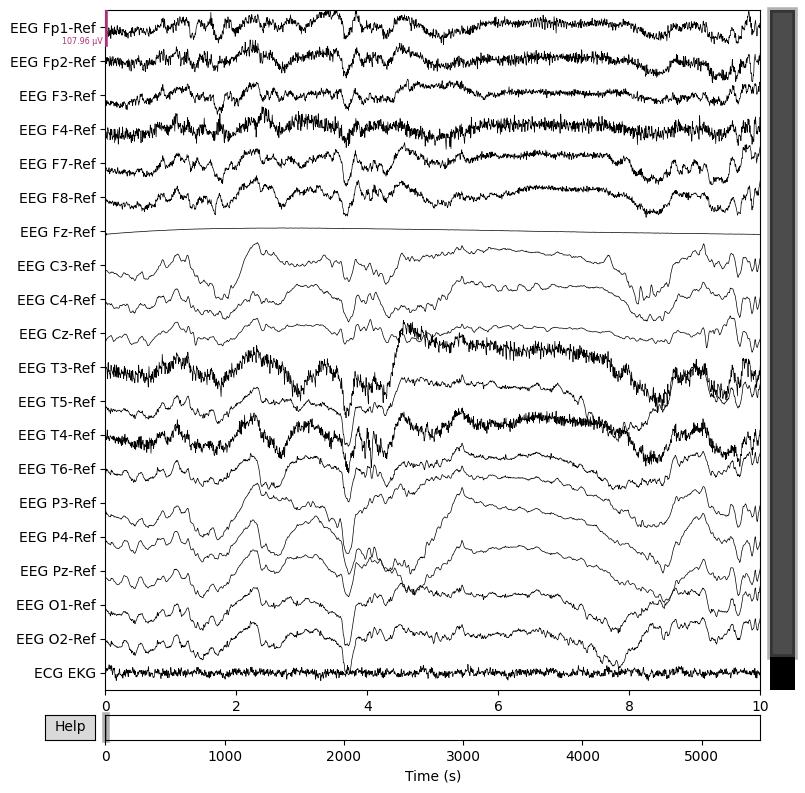

In [ ]:
# EDF - файл содержит многоканальную запись ЭЭГ
# ECG - файл содержит запись электрокардиограммы
data_from_raw_edf.plot(scalings = 'auto', show = False)
# список каналов из файла EDF
print(data_from_raw_edf.ch_names)

In [ ]:
#время приступ узнаем из аннотации из базы данных
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
print('число отчетов во временном ряду:',len(eeg_times))

# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 1*2958 -480)[0][0]
t_index_end = np.where(eeg_times > 1*3113 + 480)[0][0]
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

# удалаем ненужные сигналы из массива данных ЭЭГ
# в случае сигнала EEG_21 8 канал 'Value MKR+-MKR-'
eeg_data = np.delete(eeg_data, [len(eeg_data)-1], axis = 0)

число отчетов во временном ряду: 1406208


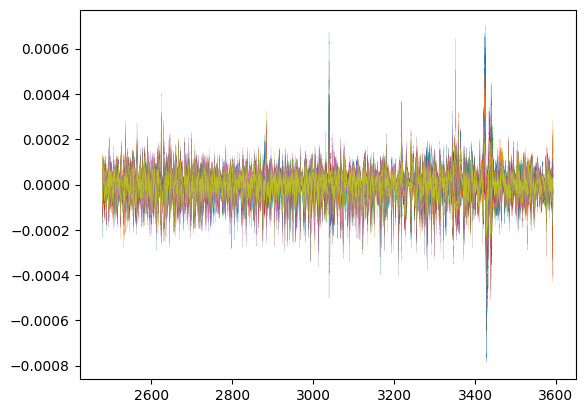

In [ ]:
for i in range(len(data_from_raw_edf.ch_names)-2):
    plt.plot(t, eeg_data[i, t_index_begin:t_index_end],linewidth = 0.1)
plt.show()

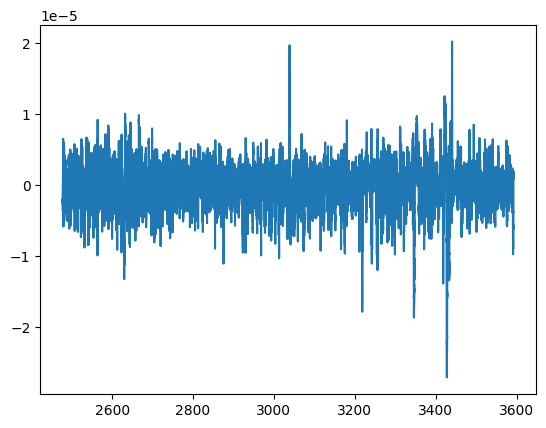

In [ ]:
# сделаем простой устредненный сигнал - все каналы в один массив
y=[]
for i in range(len(eeg_data)-2):
    y =+ eeg_data[i, t_index_begin:t_index_end]
y =y/(len(eeg_data)-1)
plt.plot(t,y)

# Пример фильтрации сигналов

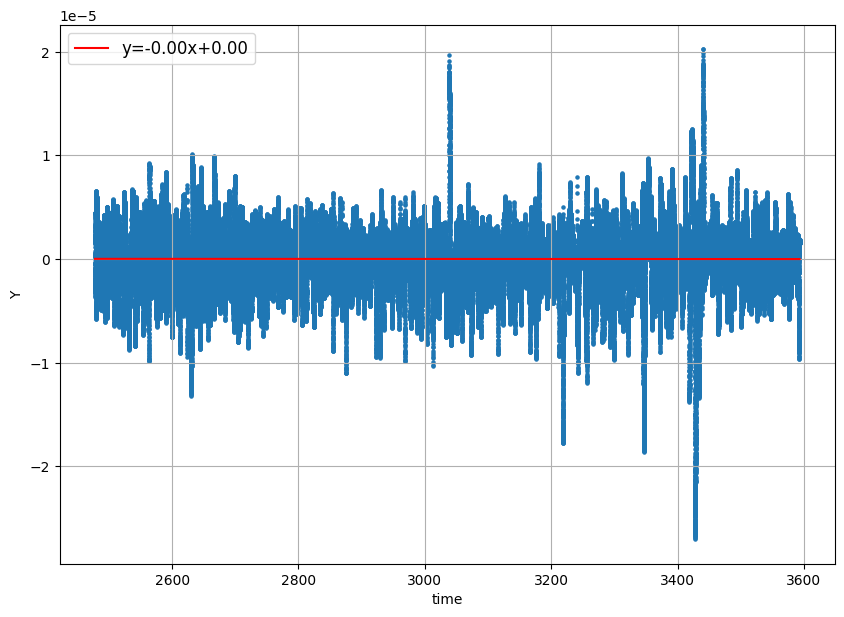

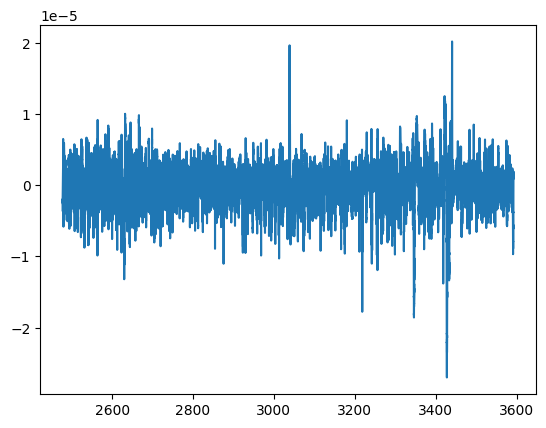

In [ ]:
slope, intercept = Detrending.line_fit(t, y)
Detrending.plot(t,y,slope, intercept)

y = Detrending.trend_off(t,y)
plt.plot(t,y)

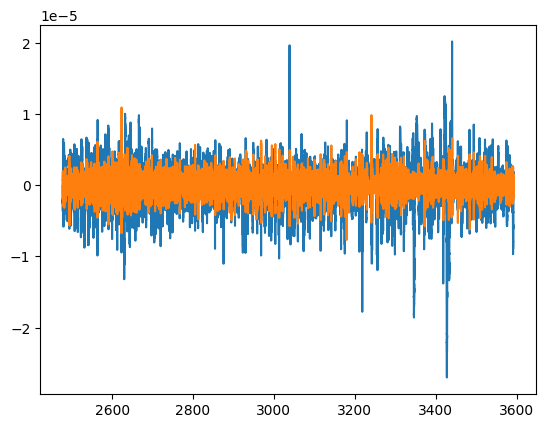

In [ ]:
# Пример предобработки: фильтрация сигнала
fs = len(t)/(T)  # частота дискретизации
lowcut = 1 # нижняя частота среза фильтра
highcut = 60 # верхняя частота среза фильтра
y_filt = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=y, lowcut=lowcut, highcut=highcut, fs=fs)
plt.plot(t,y, t, y_filt)
y = y_filt

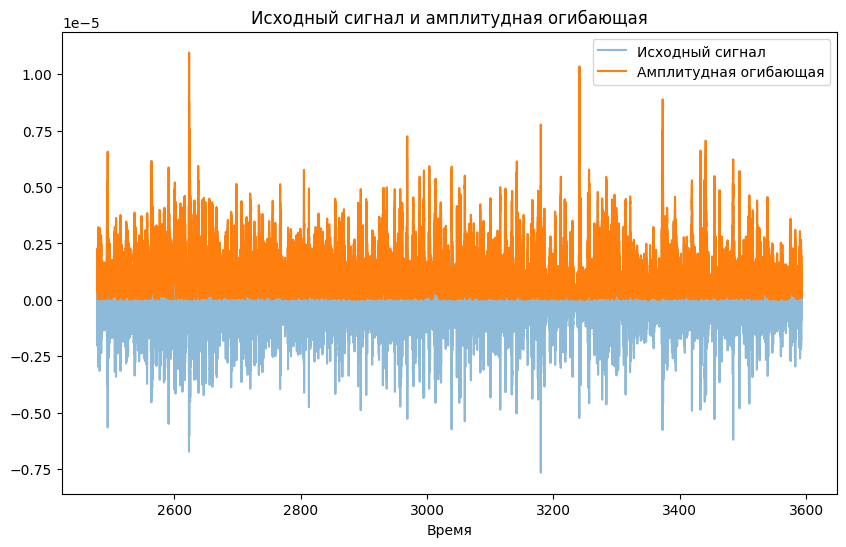

In [ ]:
# Применяем преобразование Гильберта
analytic_signal = my_func_hilbert(y)
amplitude_envelope = np.abs(analytic_signal)  # Используем амплитуду для амплитудной огибающей

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Исходный сигнал', alpha=0.5)
plt.plot(t, amplitude_envelope, label='Амплитудная огибающая')


plt.title('Исходный сигнал и амплитудная огибающая')
plt.xlabel('Время')
plt.legend()

plt.show()

In [ ]:
# Определение частотных диапазонов
delta_band = (0.5, 4)
theta_band = (4, 8)
alpha_band = (8, 13)
beta_band = (13, 30)
gamma_band = (30, 75)

band_names = ('delta','theta','alpha','beta','gamma')
band_value = (0.5, 4, 8, 13, 30, 50)
fs = int(len(t)/(T))  # частота дискретизации

<Figure size 640x480 with 0 Axes>

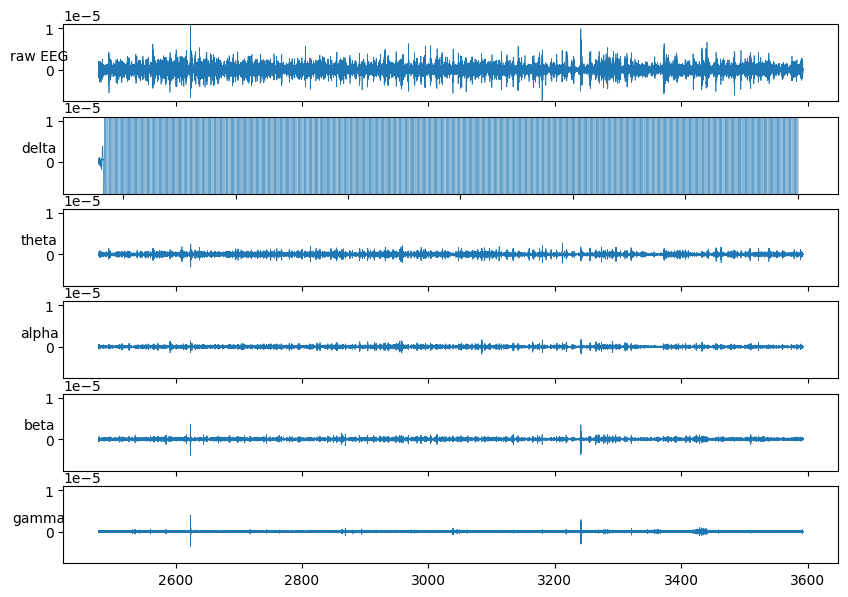

In [ ]:
fig = plt.figure()
fig, ax = plt.subplots(6,1,figsize=(10,7))
ax[0].set_ylim(np.min(y), np.max(y))
ax[0].plot(t, y,linewidth = 0.5)
ax[0].set_ylabel('raw EEG', rotation = 0)

for i in range(1,6):
    ax[i].set_ylim(np.min(y), np.max(y))
    #ax[i-1].set_yticklabels(np.arange(-25, 25, step=25))
    #ax[i-1].set_yticklabels([])
    ax[i-1].set_xticklabels([])
    ax[i].set_ylabel(band_names[i-1], rotation = 0)
    filtered_signals = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=y, lowcut=band_value[i-1], highcut=band_value[i], fs=fs)
    ax[i].plot(t, filtered_signals,linewidth = 0.5)

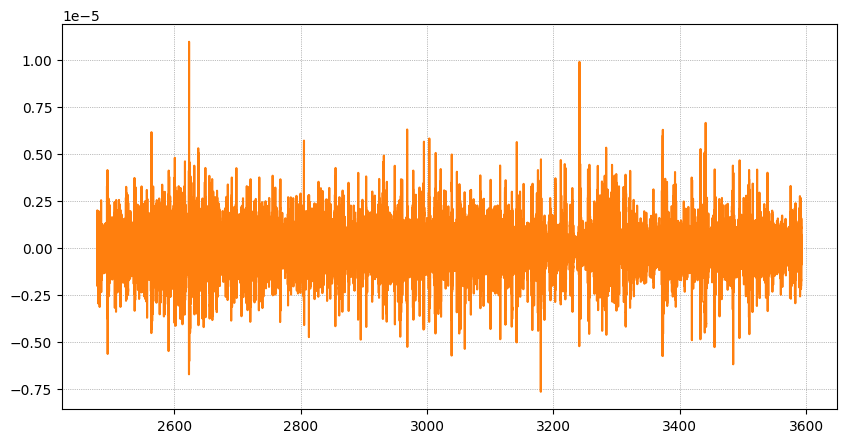

In [ ]:
# График отфильтрованного сигнала во времени
plt.figure(figsize=(10, 5))
plt.plot(t,filtered_signals)
plt.plot(t,y)
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()

# Пример визуализация медицинских временных рядов

# Характеристики сигнала

## Визуализация во временной области

In [ ]:
# визуализация каналов ЭЭГ
from matplotlib.ticker import FormatStrFormatter

sublplot_EEG_number = 18
fig = plt.figure()
fig, ax = plt.subplots(sublplot_EEG_number,1,figsize=(10,5))

for i in range(1,sublplot_EEG_number+1):
    #ax = fig.add_subplot(8, 1, i)
    ax[i-1].set_ylim(-0.0001, 0.0001)
    #ax[i-1].set_yticklabels(np.arange(-25, 25, step=25))
    ax[i-1].set_yticklabels([])
    ax[i-1].set_xticklabels([])
    ax[i-1].set_ylabel(data_from_raw_edf.ch_names[i-1], rotation = 0)
    ax[i-1].plot(t, eeg_data[i-1, t_index_begin:t_index_end],linewidth = 0.1)

In [ ]:
for i in range(7):
    plt.plot(t, eeg_data[i, t_index_begin:t_index_end],linewidth = 0.1)
plt.show()

In [ ]:
# График сигнала во времени
plt.figure(figsize=(10, 5))
plt.plot(t,y)
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()
np.shape(y)

In [ ]:
#способ визуализировать часть сигнала
index_view = np.arange(150,750,1)
plt.figure(figsize=(10, 5))
plt.plot(t[index_view], y[index_view])
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()

In [ ]:
from pyedflib import highlevel
signals, signal_headers, header = highlevel.read_edf(edf_path)
print(signal_headers[0]['sample_frequency']) # prints 256

f = pyedflib.EdfReader(edf_path)
#f.readAnnotations
#f.getPatientAdditional()
#f.getPatientCode()
y = f.readSignal(0,0,1000)
plt.plot(y)

NameError: name 'edf_path' is not defined

In [ ]:
import pyedflib

In [ ]:
!pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.3 MB/s eta 0:00:00


In [ ]:
from scipy.signal import welch

In [ ]:
# Пример извлечения характеристик: вычисление спектральных характеристик
def compute_spectral_features(signal, fs):
    f, psd = welch(signal, fs=fs)
    spectral_features = {'mean_power': np.mean(psd), 'max_power': np.max(psd)}
    return spectral_features

spectral_features = np.apply_along_axis(compute_spectral_features, axis=0, arr=filtered_signals, fs=fs)


In [ ]:
print(spectral_features)

{'mean_power': 1.3441566896526764e-17, 'max_power': 1.4976028286936584e-16}


## Визуализация сигнала: спектр Фурье

число точек в диапазоне преобразования Фурье: 142720
максимальная частота 127.9995515679357


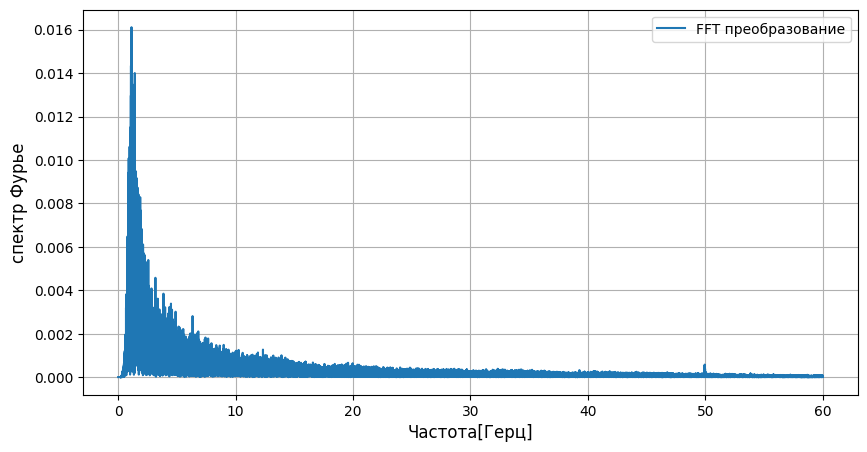

In [ ]:
from scipy.fft import fft, fftfreq

y = y_filt
yfft = fft(y)
xf = fftfreq(N, T/N)[:N//2]
yf = np.abs(yfft[0:N//2])

# устанавливаем максимальную частоту для отображения на графике преобразования Фурье
f_viewmax = 60
if len(np.where(xf > f_viewmax)[0]) == 0:
  index_f_viewmax = len(xf)
else:
  index_f_viewmax = np.where(xf > f_viewmax)[0][0]
print('число точек в диапазоне преобразования Фурье:',len(xf))
print('максимальная частота', xf[-1])
# спект Фурье симметричен относительно нуля, поэтому берем только правую его часть
plt.figure(figsize=(10, 5))
plt.plot(xf[0:index_f_viewmax], yf[0:index_f_viewmax], label='FFT преобразование')
plt.xlabel('Частота[Герц]', fontsize=12)
plt.ylabel('спектр Фурье', fontsize=12)
#plt.xticks(np.arange(1, np.max(xf[0:100]), 2))
plt.grid()
plt.legend()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


<ipython-input-23-1639ef99e3d3>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data_from_raw_edf.plot_psd(fmin=1, fmax=f_viewmax, tmax=np.inf, show=False)


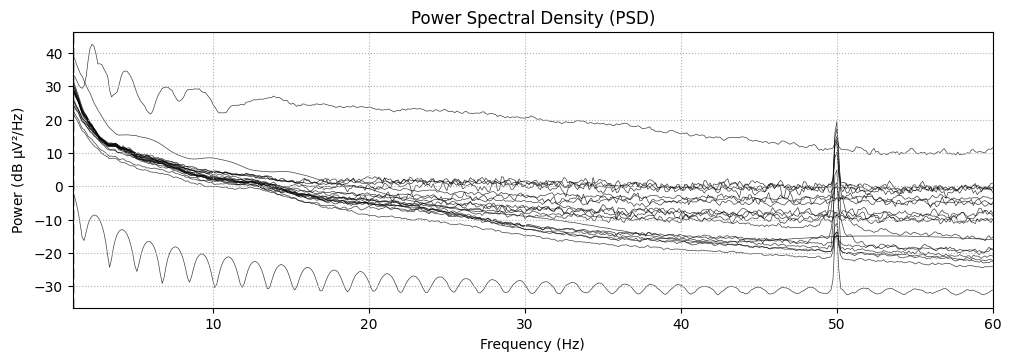

In [ ]:
# Построение спектра плотности мощности
data_from_raw_edf.plot_psd(fmin=1, fmax=f_viewmax, tmax=np.inf, show=False)
plt.title('Power Spectral Density (PSD)')
plt.show()

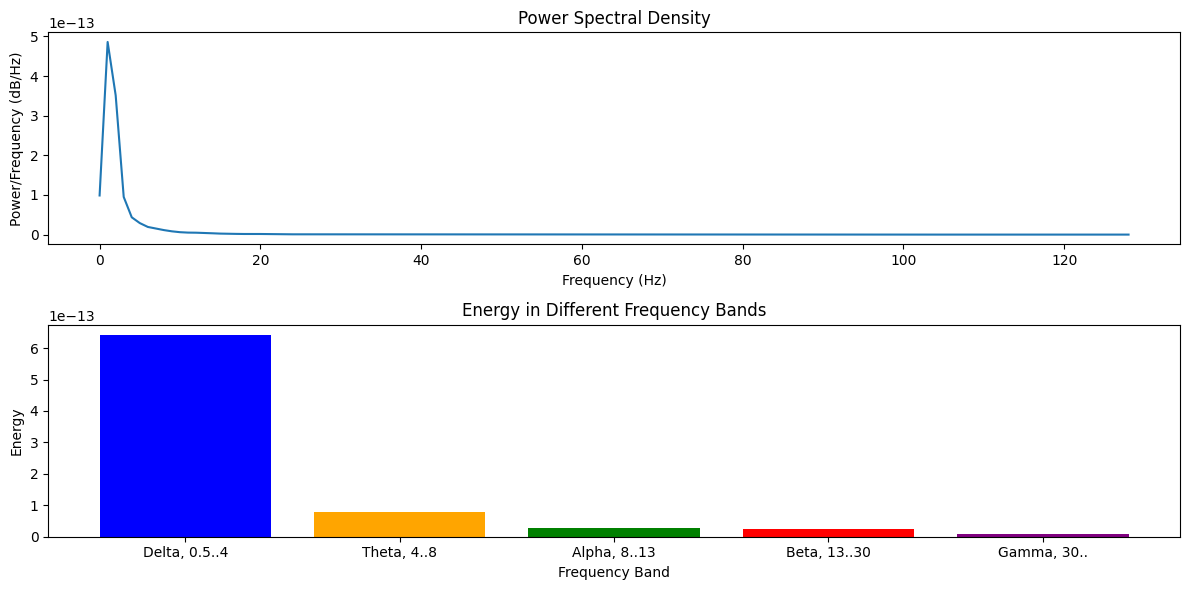

In [ ]:
from scipy.signal import welch

# Функция для вычисления энергии в заданном частотном диапазоне
def compute_energy_in_frequency_band(freqs, psd, band):
    indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
    energy = np.trapz(psd[indices], freqs[indices])
    return energy

# Функция для построения спектрограммы и вычисления энергии в различных частотных диапазонах
def plot_spectrogram_and_energy(signal, sample_rate):
    # Вычисление мощности спектра с помощью метода Велча
    freqs, psd = welch(signal, sample_rate)#, nperseg=1024)

    # Определение частотных диапазонов
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, 100)

    # Вычисление энергии в каждом частотном диапазоне
    energy_delta = compute_energy_in_frequency_band(freqs, psd, delta_band)
    energy_theta = compute_energy_in_frequency_band(freqs, psd, theta_band)
    energy_alpha = compute_energy_in_frequency_band(freqs, psd, alpha_band)
    energy_beta  = compute_energy_in_frequency_band(freqs, psd, beta_band)
    energy_gamma = compute_energy_in_frequency_band(freqs, psd, gamma_band)

    # Построение спектрограммы
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, psd)
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    # Построение энергии в различных частотных диапазонах
    plt.subplot(2, 1, 2)
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    energies = [energy_delta, energy_theta, energy_alpha, energy_beta, energy_gamma]
    plt.bar(bands, energies, color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.title('Energy in Different Frequency Bands')
    plt.xlabel('Frequency Band')
    plt.xticks(np.arange(5), ('Delta, 0.5..4', 'Theta, 4..8', 'Alpha, 8..13', 'Beta, 13..30', 'Gamma, 30..'))
    plt.ylabel('Energy')

    plt.tight_layout()
    plt.show()

#sample_rate частота дискретизации
sample_rate = fs
plot_spectrogram_and_energy(y, sample_rate)


# Вейвлет преобразования CWT

In [ ]:
# перечень вейвлетов
wavlist_continuous = pywt.wavelist(kind='continuous')
wavlist_discrete = pywt.wavelist(kind='discrete')

In [ ]:
# устанавливаем максимальное значение сдвига
# не путать с частотой

#For the cmor, fbsp and shan wavelets, the user can specify a specific a normalized center frequency.
#A value of 1.0 corresponds to 1/dt where dt is the sampling period.
#In other words, when analyzing a signal sampled at 100 Hz,
#a center frequency of 1.0 corresponds to ~100 Hz at scale = 1.
#This is above the Nyquist rate of 50 Hz, so for this particular wavelet, one would analyze a signal using scales >= 2.

scale_max = 300
scale_min = 3
# массив точек с масштабом (линейный и логарифмический масштаб)
scales = np.linspace(scale_min, scale_max, num = 25, endpoint=True)
#scales = np.logspace(np.log10(scale_min), np.log10(scale_max), num = 25, endpoint=True, base=10.0)

wavelet_core = 'morl'
#dt = t[1] - t[0]
fs = len(t)/(T)  # частота дискретизации
dt = 1/ fs
coef, freqs = pywt.cwt(y, scales, wavelet_core, sampling_period = dt)

# freqs = These are normalized frequencies, which means that you need
# to multiply them by your sampling frequency = fs
# to turn them into actual frequencies.

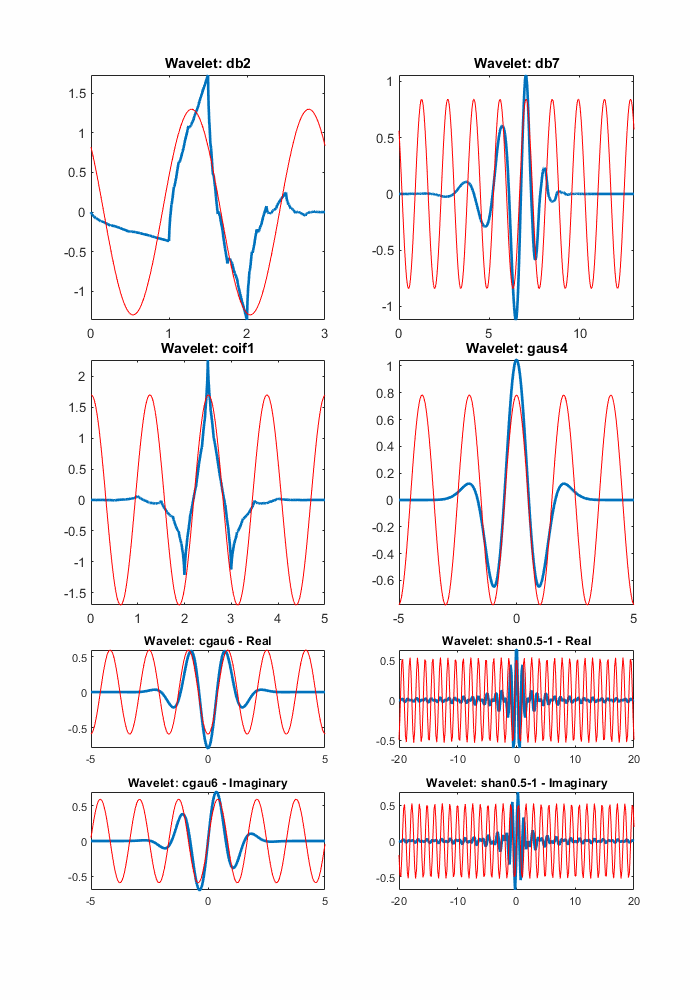

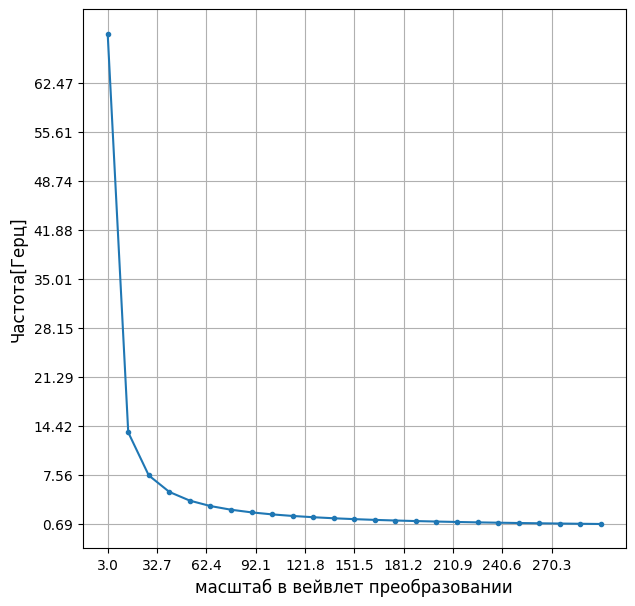

In [ ]:
# вейвлет-преобразование построено относительно масштаба материнского вейвлета
# чтобы вернуться в область частот - необходимо перевести масштаб в частоту!
#f = pywt.scale2frequency(wavelet_core, scales)/(T/N)
f = pywt.scale2frequency(wavelet_core, scales)/dt

# изобразим график зависимости частоты и масштаба
plt.figure(figsize=(7, 7))
plt.grid()
plt.yticks(np.arange(min(freqs), max(freqs), (max(freqs) - min(freqs))/10))
plt.xticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
plt.ylabel('Частота[Герц]', fontsize=12)
plt.xlabel('масштаб в вейвлет преобразовании', fontsize=12)
plt.plot(scales, freqs,'.-')

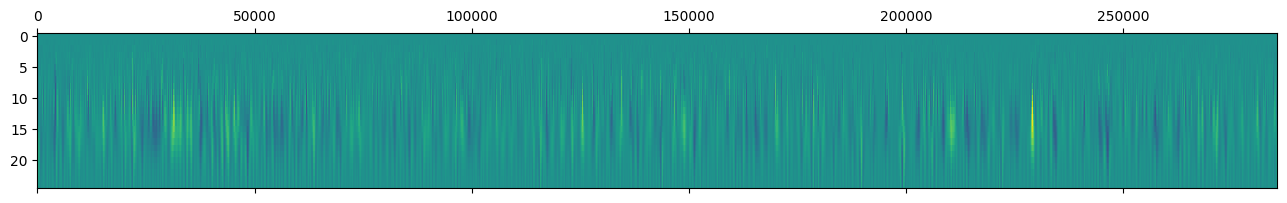

In [ ]:
plt.matshow(coef,aspect = 'auto')

Text(0.5, 1.0, 'сигнал в области времени')

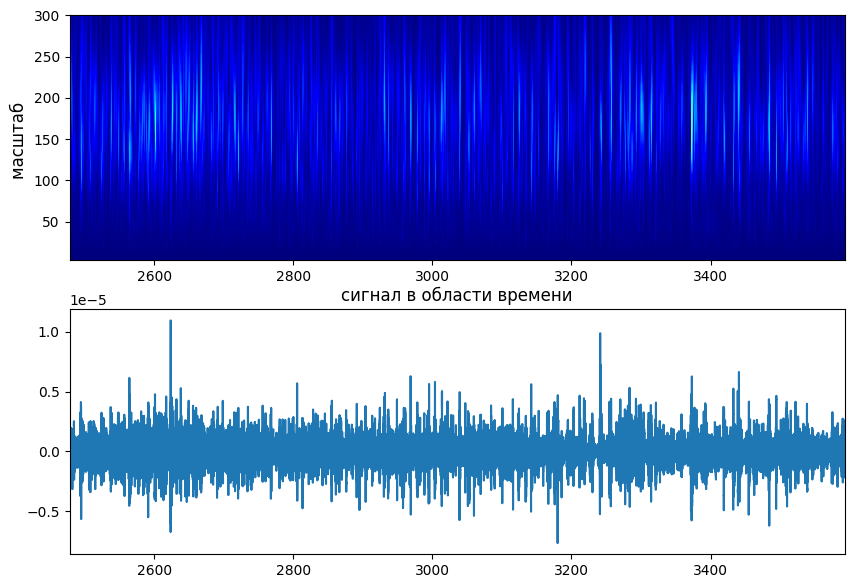

In [ ]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(211)
#plt.imshow(abs(coef), extent=[t[0], t[-1], scale_max, 0], interpolation='bilinear', cmap='plasma', aspect='auto')
plt.imshow(abs(coef), cmap='jet', aspect='auto', extent=[t[0], t[-1], max(scales), min(scales)], vmax=abs(coef).max(), vmin=abs(coef).min())
plt.gca().invert_yaxis ()
plt.ylabel('масштаб ', fontsize=12)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t, y)
ax2.set_title("сигнал в области времени")

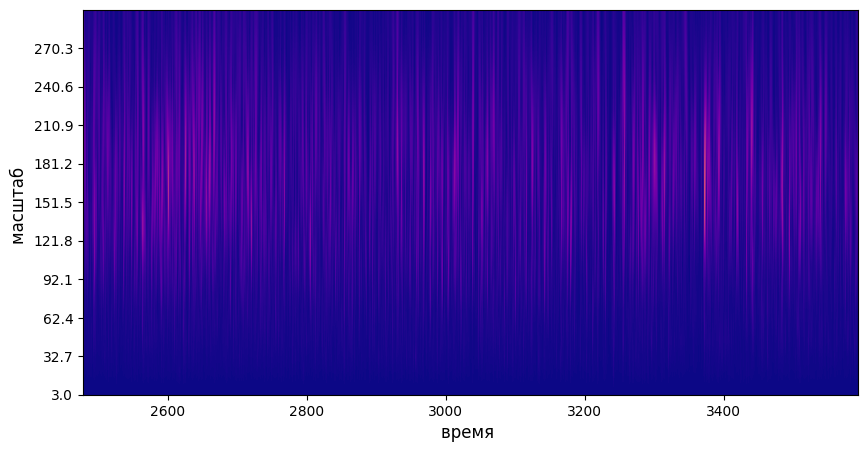

In [ ]:
#Plotting scalogram
plt.figure(figsize=(10, 5))
plt.imshow(abs(coef), extent=[t[0], t[-1], max(scales), min(scales)], interpolation='bilinear', cmap='plasma', aspect='auto')
#plt.imshow(abs(coef), interpolation='bilinear', cmap='plasma', aspect='auto')
plt.gca().invert_yaxis ()
plt.yticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
plt.ylabel('масштаб ', fontsize=12)
plt.xlabel('время ', fontsize=12)
plt.show()

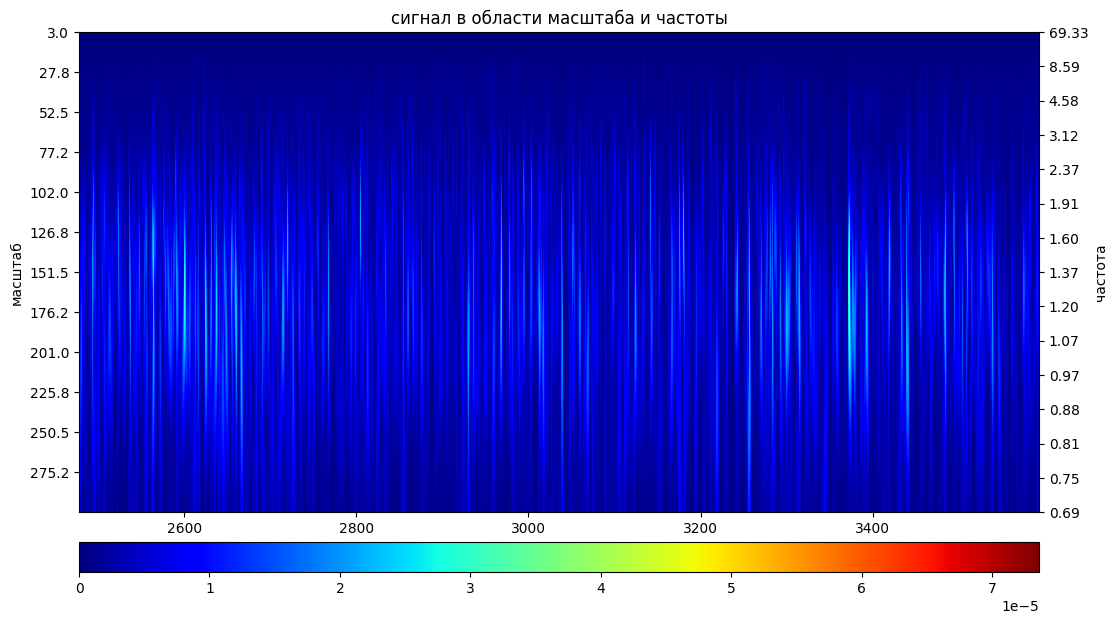

In [ ]:
from matplotlib.figure import cbar
from matplotlib.ticker import FuncFormatter
import mpl_toolkits.axes_grid1 as axes_grid1
import matplotlib.ticker as ticker

#Plotting dual axis scalogram
f1 = plt.figure()
f1.set_size_inches(12, 6)


ax1 = axes_grid1.host_axes([0.1, 0.1, 0.8, 0.80])
axc = f1.add_axes([0.1, 0, 0.8, 0.05])
im1 = ax1.imshow(abs(coef), cmap='jet', aspect='auto', interpolation='bilinear',
                 extent=[t[0], t[-1], max(scales), min(scales)],
                 vmax=abs(coef).max(), vmin=-abs(coef).min())

cbar.Colorbar(axc, im1, orientation='horizontal')

#ax1.invert_yaxis()
ax1.set_yticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/12))


ax2 = ax1.twinx()
# make ticklabels on the top invisible
ax2.axis["top"].toggle(ticklabels=False)

formatter = FuncFormatter(lambda x, pos: '{:0.2f}'.format(pywt.scale2frequency(wavelet_core, x)/dt))
ax2.yaxis.set_major_formatter(formatter)
ax2.set_ylim(ax1.get_ylim())
#ax2.invert_yaxis()

# make number ticks what we want
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_major_locator(ticker.LinearLocator(numticks = 15))


ax2.set_ylabel('частота')
ax1.set_ylabel('масштаб')
ax2.set_xlabel('время')

ax1.set_title("сигнал в области масштаба и частоты")

plt.show()

# Дискретное вейвлет преобразование DWT

https://discourse.julialang.org/t/plots-with-a-secondary-non-linear-axis-scale/56661
https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

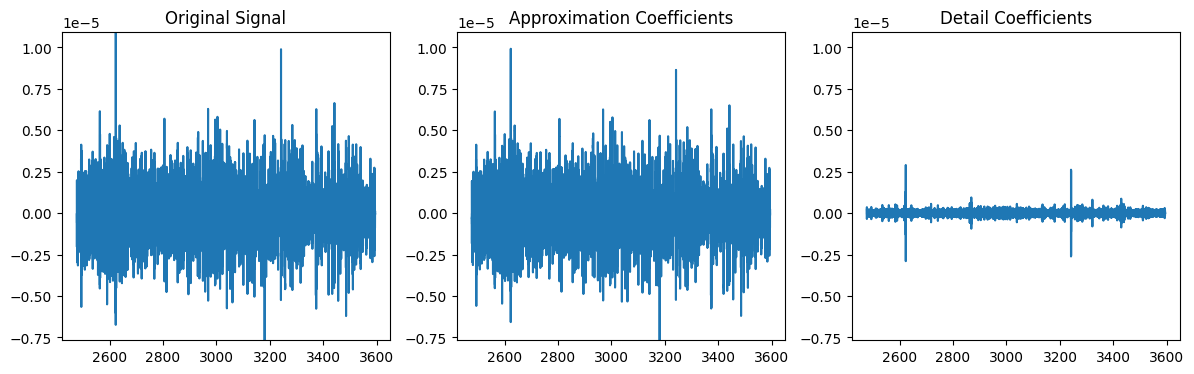

In [ ]:
# Generate the signal
#t = np.linspace(0, 1, 100, endpoint=False)
#signal = np.cos(2.0 * np.pi * 7 * t) + np.sin(2.0 * np.pi * 13 * t)

# Apply DWT
coeffs = pywt.dwt(y, 'db1')
cA, cD = coeffs

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.ylim(min(y),max(y))
plt.plot(t, y)
plt.title("Original Signal")

plt.subplot(1, 3, 2)
plt.ylim(min(y),max(y))
plt.plot(t, pywt.upcoef('a', cA, 'db1',take = len(t)))
plt.title("Approximation Coefficients")

plt.subplot(1, 3, 3)
plt.plot(t, pywt.upcoef('d', cD, 'db1', take = len(t)))
plt.ylim(min(y),max(y))
plt.title("Detail Coefficients")

plt.tight_layout()
plt.show()

In [ ]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [ ]:
waveletname = 'db4'
dwt_coeffs = pywt.wavedec(y, waveletname, level=5)

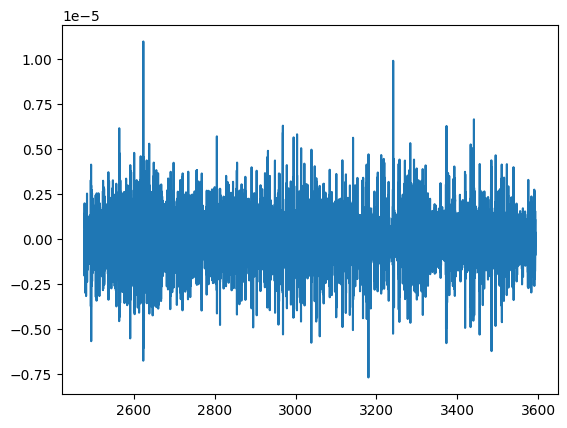

In [ ]:
y_idwt = pywt.waverec(dwt_coeffs, wavelet = waveletname, mode = 'zero')
plt.plot(t,y_idwt)

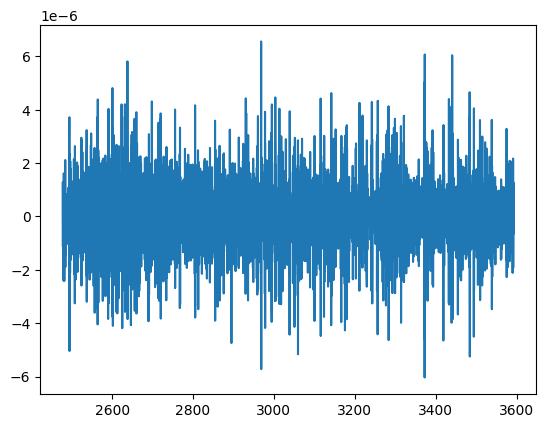

In [ ]:
# восстановление сигнала с помощью обратного дискретного вейвлет преобразования
plt.plot(t, pywt.upcoef('a', dwt_coeffs[0][:], waveletname, level = 5, take = len(y)))

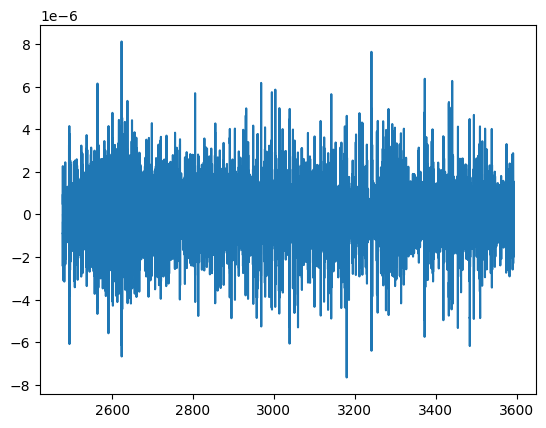

In [ ]:
y_5level_idwt = \
  pywt.upcoef('a', dwt_coeffs[0][:], waveletname, level = 5, take = len(y))\
+ pywt.upcoef('d', dwt_coeffs[1][:], waveletname, level = 5, take = len(y))\
+ pywt.upcoef('d', dwt_coeffs[2][:], waveletname, level = 4, take = len(y))\
+ pywt.upcoef('d', dwt_coeffs[3][:], waveletname, level = 3, take = len(y))\
+ pywt.upcoef('d', dwt_coeffs[4][:], waveletname, level = 2, take = len(y))\
+ pywt.upcoef('d', dwt_coeffs[5][:], waveletname, level = 1, take = len(y))
plt.plot(t,y_5level_idwt)

<Figure size 640x480 with 0 Axes>

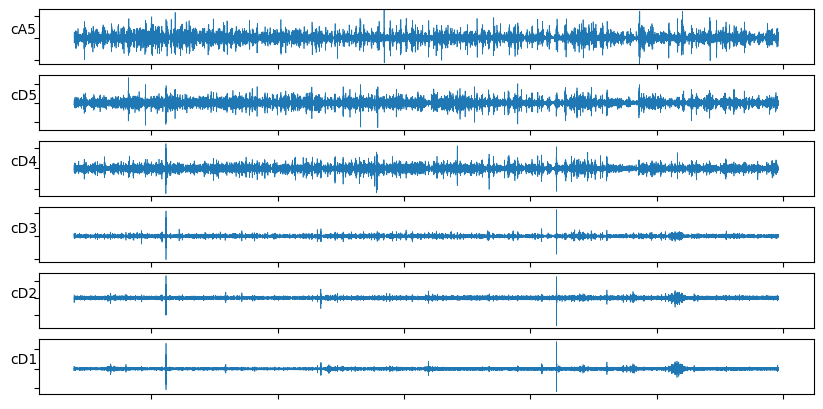

In [ ]:
plot_as_level = 5
fig = plt.figure()
fig, ax = plt.subplots(plot_as_level + 1,1,figsize=(10,5))
y_cA = pywt.upcoef('a', dwt_coeffs[0][:], waveletname, level = plot_as_level, take = len(y))
ax[0].set_ylim(min(y_cA), max(y_cA))
ax[0].set_ylabel('cA%i'%plot_as_level, rotation = 0)
ax[0].set_yticklabels([])
ax[0].plot(t, y_cA,linewidth = 0.5)


for i in range(1,plot_as_level + 1):
    #ax = fig.add_subplot(8, 1, i)
    #ax[i].set_ylim(min(y_cA), max(y_cA))
    #ax[i-1].set_yticklabels(np.arange(-25, 25, step=25))
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_ylabel('cD%i'%(plot_as_level + 1 - i), rotation = 0)
    y_cD = pywt.upcoef('d', dwt_coeffs[i][:], waveletname, level = plot_as_level + 1 - i , take = len(y))
    ax[i].plot(t, y_cD,linewidth = 0.5)

<Figure size 640x480 with 0 Axes>

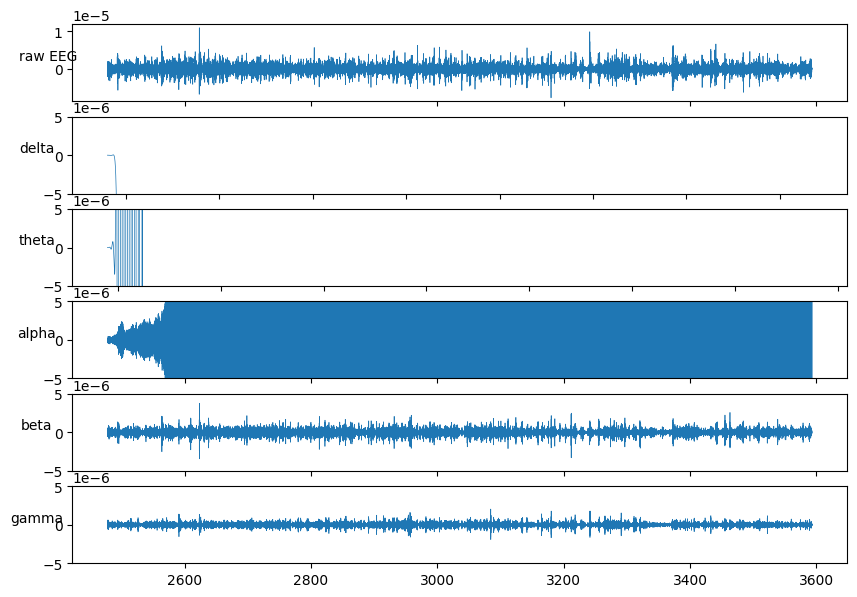

In [ ]:
fig = plt.figure()
fig, ax = plt.subplots(6,1,figsize=(10,7))
#ax[0].set_ylim(-0.000005, 0.000005)
ax[0].plot(t, y,linewidth = 0.5)
ax[0].set_ylabel('raw EEG', rotation = 0)

for i in range(1,6):
    ax[i].set_ylim(-0.000005, 0.000005)
    #ax[i-1].set_yticklabels(np.arange(-25, 25, step=25))
    #ax[i-1].set_yticklabels([])
    ax[i-1].set_xticklabels([])
    ax[i].set_ylabel(band_names[i-1], rotation = 0)
    filtered_signals = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=y, lowcut=band_value[i-1], highcut=band_value[i], fs=fs)
    ax[i].plot(t, filtered_signals,linewidth = 0.5)

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Text(0.5, 1.0, 'ошибка восстановления сигнала')

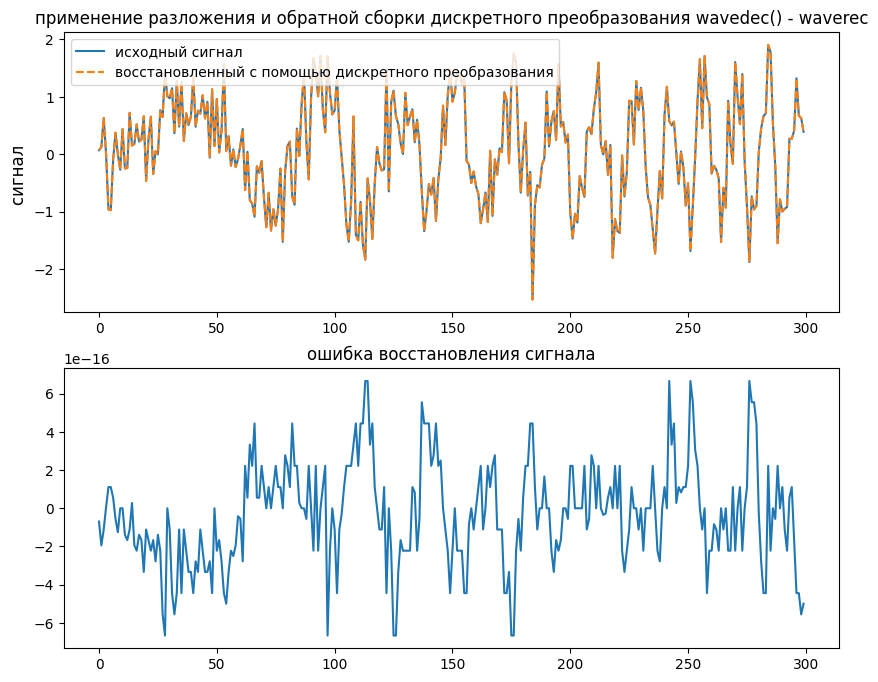

In [ ]:
num = 300
x = np.linspace(0, 1, num=num)
signal = np.sin(25 * np.pi * x**2) + np.random.normal(0, scale=0.5, size=len(x))

coeffs = pywt.wavedec(signal, 'db4', level=8)
reconstructed_signal = pywt.waverec(coeffs, 'db4')

plt.figure(figsize=(10, 8))

ax1 = plt.subplot(211)
plt.plot(signal[:num], label='исходный сигнал')
plt.plot(reconstructed_signal[:num], label='восстановленный с помощью дискретного преобразования', linestyle='--')
ax1.legend(loc='upper left')
ax1.set_title('применение разложения и обратной сборки дискретного преобразования wavedec() - waverec')

plt.ylabel('сигнал ', fontsize=12)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(signal[:num] - reconstructed_signal[:num])
ax2.set_title("ошибка восстановления сигнала")

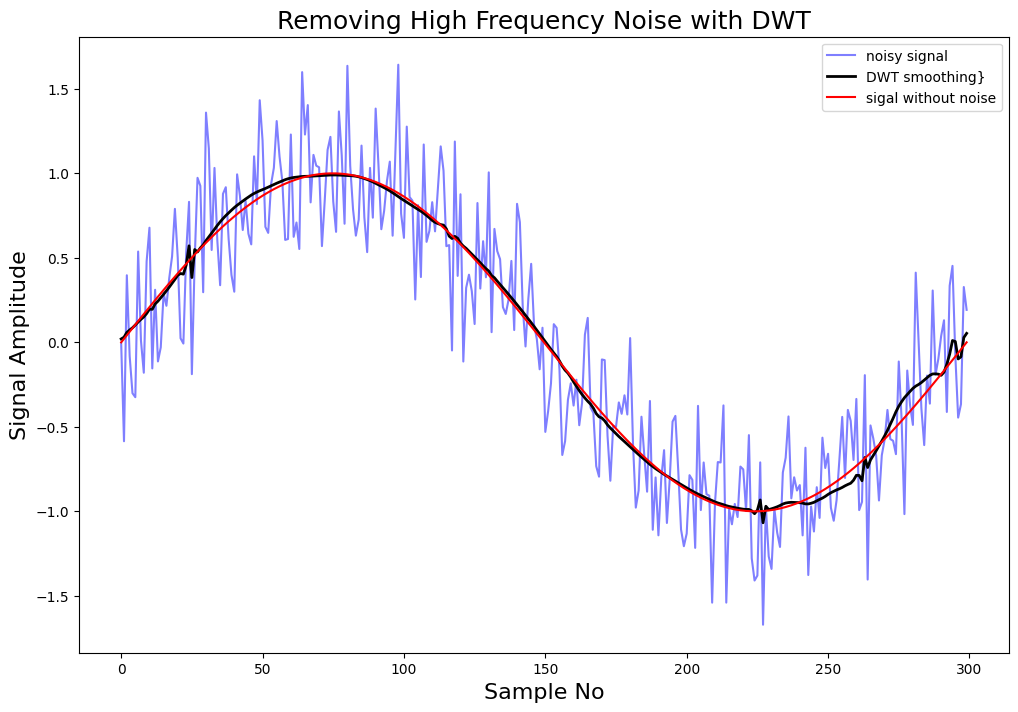

In [ ]:
import random
num = 300
x = np.linspace(0, 1, num=num)
signal = np.sin(2*np.pi * x) + np.random.normal(0, scale=0.3, size=len(x))
signal_ideal = np.sin(2*np.pi * x)

def lowpassfilter(signal, thresh = 0.7, wavelet = "db4"):
    thresh = thresh * np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='noisy signal')
rec = lowpassfilter(signal, 0.4)
ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
ax.plot(signal_ideal, 'r', label='sigal without noise')
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

In [ ]:
from pylab import *
from scipy import *
import scipy.io.wavfile as wavfile

In [ ]:
from scipy.fft import fft, fftfreq

yfft = fft(y)
xf = fftfreq(N, T/N)[:N//2]
amp_f = np.abs(yfft[0:N//2])
fi_f = np.unwrap(np.angle(yfft[:N//2]))

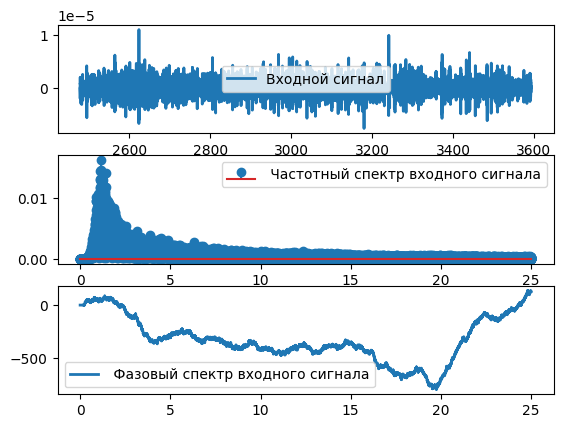

In [ ]:
plt.subplot(3, 1, 1)
st = 'Входной сигнал'
plt.plot(t,y,linewidth=2, label=st)
plt.legend(loc='center')

#строим не весь спектр, а только до конкретного значения часторы Hz
Hz = np.where(xf > 25)[0][0]

plt.subplot(3, 1, 2)
st = ' Частотный спектр входного сигнала'
#plt.plot(xf[0:Hz], amp_f[0:Hz], linewidth=2, label=st)
plt.stem(xf[0:Hz], amp_f[0:Hz],label=st)
legend(loc='best')

plt.subplot(3, 1, 3)
st = ' Фазовый спектр входного сигнала'
#pX=np.unwrap(np.angle(yfft))
plt.plot(xf[0:Hz], fi_f[0:Hz], linewidth=2, label=st)
plt.legend(loc='best')

plt.show()

In [ ]:
def scalogram(data,t):
    bottom = 0
    vmin = min(map(lambda x: min(abs(x)), data))
    vmax = max(map(lambda x: max(abs(x)), data))
    gca().set_autoscale_on(False)
    for row in range(0, len(data)):
        scale = 2.0 ** (row - len(data))
        imshow(
            array([abs(data[row])]),
            cmap = 'jet',
            aspect = 'auto',
            interpolation = 'nearest',
            vmin = vmin,
            vmax = vmax,
            extent = [t[0], t[-1], bottom, bottom + scale])
        bottom += scale

<Figure size 640x480 with 0 Axes>

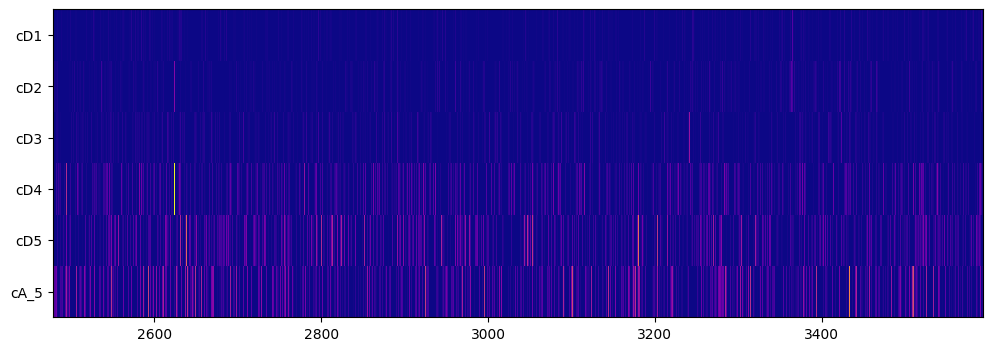

In [ ]:
#waveletname = 'db4'
d_coeffs = pywt.wavedec(y, waveletname, level=5)

plt.figure()
plt.figure(figsize=(12, 4))
for i, ci in enumerate(d_coeffs):
    #plt.imshow(ci.reshape(1, -1), extent=[t[0], t[-1], i + 0.5, i + 1.5], cmap='jet', aspect='auto', interpolation='nearest')
    plt.imshow(ci.reshape(1, -1), extent=[t[0], t[-1], i + 0.5, i + 1.5],
               cmap='plasma', aspect='auto', interpolation='nearest',
               vmax=abs(ci).max(), vmin=-abs(coef).min())

#im1 = ax1.imshow(abs(coef), cmap='jet', aspect='auto', interpolation='bilinear',
#                 extent=[t[0], t[-1], max(scales), min(scales)],
#                 vmax=abs(coef).max(), vmin=-abs(coef).min())

plt.ylim(0.5, len(d_coeffs) + 0.5) # set the y-lim to include the six horizontal images
# optionally relabel the y-axis (the given labeling is 1,2,3,...)
plt.yticks(range(1, len(d_coeffs) + 1), ['cA_5', 'cD5', 'cD4', 'cD3', 'cD2', 'cD1'])

plt.show()

# Алгоритмы ICA (Independent Component Analysis)
https://mvlearn.github.io/auto_examples/decomposition/plot_group_ica_tutorial.html

In [ ]:
# пример трех графиков для смешивания параметров для фильтрации ICA
sampl_rate=1000
N = 2000
T = 40
t=np.linspace(0,T,N)
sfreq = 100
sine = 1*np.sin(2*np.pi*sfreq*t)
sawtooth = 1*signal.sawtooth(2*np.pi*sfreq*t)
square = 1*signal.square(2*np.pi*sfreq*t)

y_original = np.c_[sine,sawtooth,square]

weight = np.array([[0.2,0.2,0.6],[0.33,0.33,0.34],[0.6,0.2,0.2]])
y = np.dot(y_original, weight.T)

In [ ]:
from sklearn.decomposition import PCA, FastICA

# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
y_ica = ica.fit_transform(y)  # Reconstruct signals
W_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(y, np.dot(y_ica, W_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(y)  # Reconstruct signals based on orthogonal components

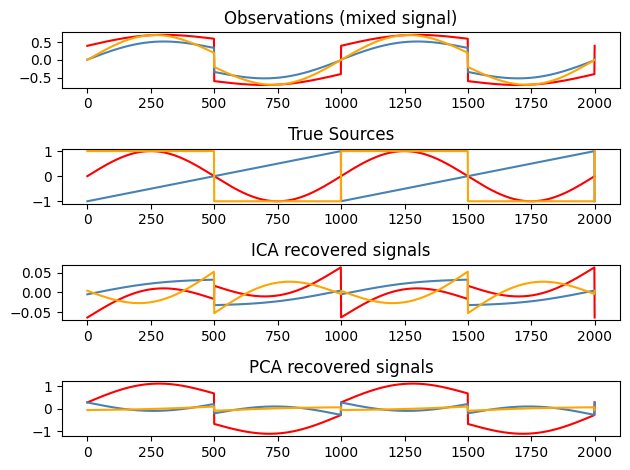

In [ ]:
plt.figure()

models = [y, y_original, y_ica, H]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

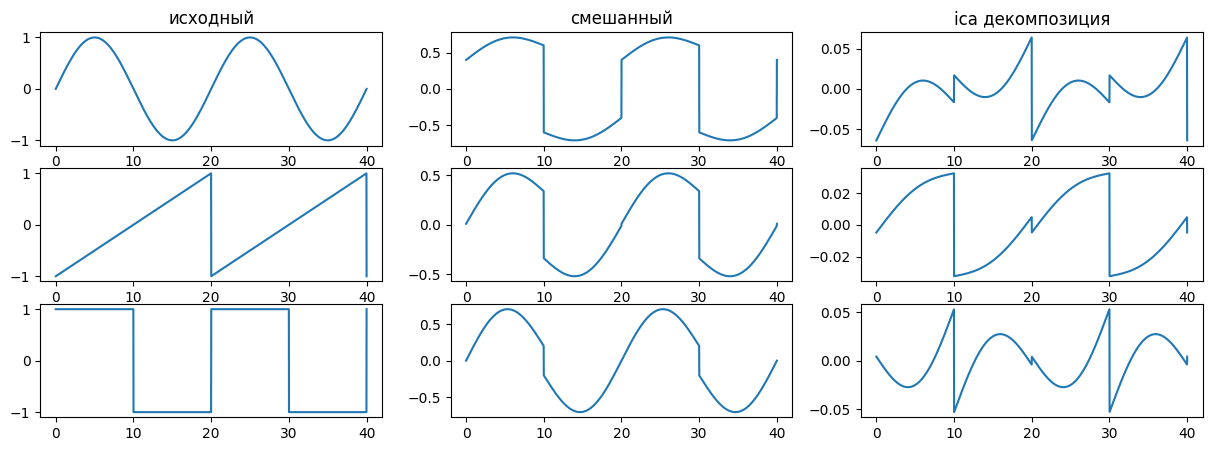

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15,5))
name = ["исходный","смешанный","ica декомпозиция"]
for i in range(y_original.shape[1]):
  ax[0, i].set_title(name[i])
  ax[i, 0].plot(t,y_original[:,i])
  ax[i, 1].plot(t,y[:,i])
  ax[i, 2].plot(t,y_ica[:,i])

In [ ]:
from mne.preprocessing import ICA
filt_raw = data_from_raw_edf .copy().filter(l_freq=1.0, h_freq=None)
ica = ICA(n_components=9, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 21 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Selecting by number: 9 components
Fitting ICA took 14.5s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,41 iterations on raw data (1406208 samples)
ICA components,9
Available PCA components,21
Channel types,eeg
ICA components marked for exclusion,—


https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

#Алгоритмы DFA (detrended flactuation analisys)

In [ ]:
!pip install hurst --quiet
!pip install MFDFA --quiet

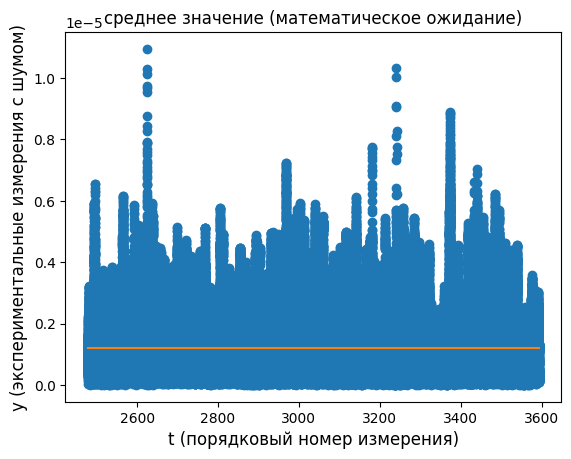

In [ ]:
y = amplitude_envelope
plt.plot(t, y, 'o')
plt.plot([t[0], t[-1]],[np.mean(y), np.mean(y)])
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y (экспериментальные измерения с шумом)', fontsize=12)
plt.title("среднее значение (математическое ожидание)")
plt.fill_between(t, np.mean(y) + np.std(y), np.mean(y) - np.std(y), color = "silver")
plt.show()

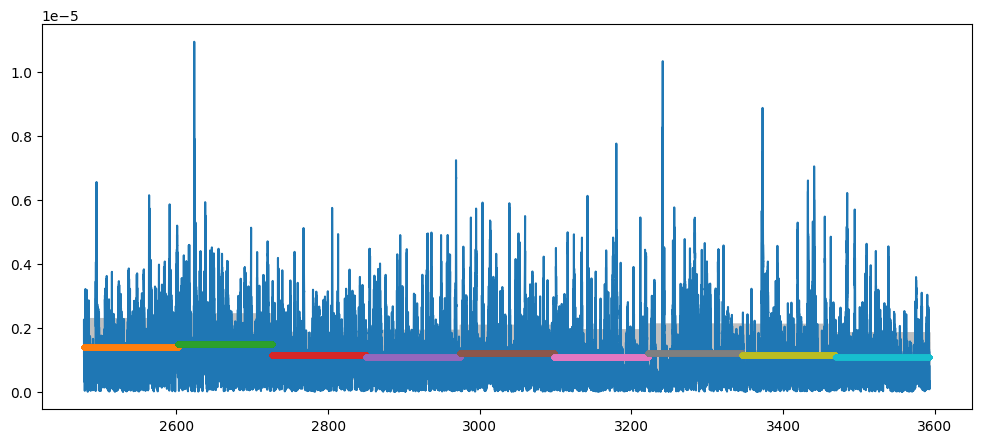

In [ ]:
window_count = 9

len_int = int(len(y)/window_count)

plt.figure(figsize = (12,5))
plt.plot(t,y)
for i in range(0,window_count):
  window_idx = range(0+i*len_int,(1+i)*len_int)
  y_window = np.mean(y[window_idx]) * np.ones(len_int)
  plt.plot(t[window_idx], y_window,".")
  plt.fill_between(t[window_idx], np.mean(y_window) + np.std(y[window_idx]), np.mean(y_window) - np.std(y[window_idx]), color = "silver")



In [ ]:
# сумма накопительным итогом (коммулятивная сумма осредненного ряда)
y_cumsum = []
y_cumsum = np.array([y[0] - np.mean(y)])
for i in range(1,len(y)):
  y_cumsum = np.append(y_cumsum, y_cumsum[i-1] + y[i] - np.mean(y))

In [ ]:
# СКО в зависимости от значения порядкового номера измерения
y_std = []
y_std = np.array([np.std(y[0]-np.mean(y))])
for i in range(1,len(y)):
  y_std = np.append(y_std, np.std(y[range(0,i)]-np.mean(y)))

In [ ]:
# Размаз в зависимости от значения порядкового номера измерения
y_R = []
y_R = np.array([(y[0]-np.mean(y))])
for i in range(1,len(y)):
  y_R= np.append(y_R, np.max(y[range(0,i)]) - np.min(y[range(0,i)]))

<ipython-input-35-aef09d179bea>:1: RuntimeWarning: divide by zero encountered in divide
  RSstat = y_R / y_std
<ipython-input-35-aef09d179bea>:1: RuntimeWarning: invalid value encountered in divide
  RSstat = y_R / y_std


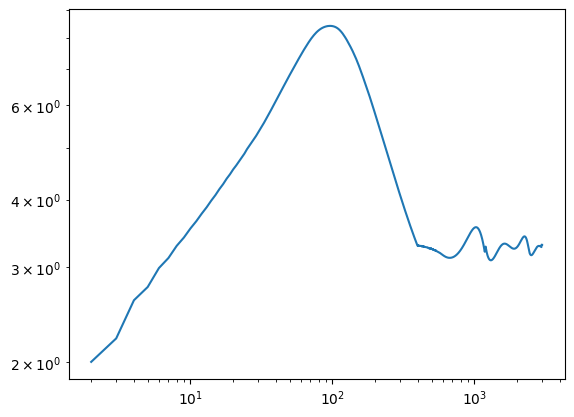

In [ ]:
RSstat = y_R / y_std
plt.loglog(RSstat)

https://mfdfa.readthedocs.io

https://github.com/LRydin/MFDFA/blob/master/MFDFA/MFDFA.py


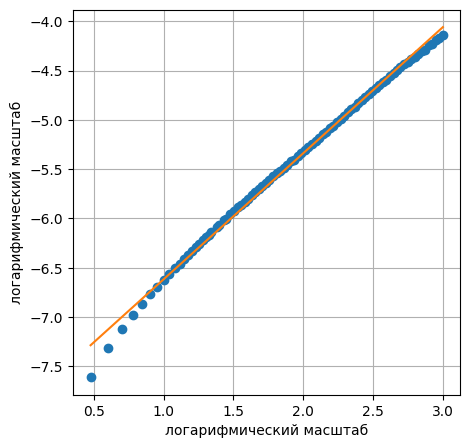

Estimated H = 1.279


In [ ]:
# Imports
from MFDFA import MFDFA

# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))

# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 2

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag, dfa = MFDFA(y, lag = lag, q = q, order = order)

# To uncover the Hurst index, lets get some log-log plots

# And now we need to fit the line to find the slope
# in a double logaritmic scales, i.e., you need to
# fit the logs of the results

del_nan = np.argwhere(np.isnan(dfa))
dfa = np.delete(dfa,del_nan[:,0])
lag = np.delete(lag,del_nan[:,0])
H_hat, C_hat = np.polyfit(np.log10(lag)[0:-1],np.log10(dfa[0:-1]),1)

plt.figure(figsize=(5, 5))
plt.plot(np.log10(lag),np.log10(dfa),"o")
tlin = np.linspace(np.log10(lag[0]),np.log10(lag[-1]), num=100)
plt.plot(tlin, H_hat*tlin + C_hat)
plt.xlabel("логарифмический масштаб")
plt.ylabel("логарифмический масштаб")
plt.grid()
plt.show()

print('Estimated H = '+'{:.3f}'.format(H_hat))

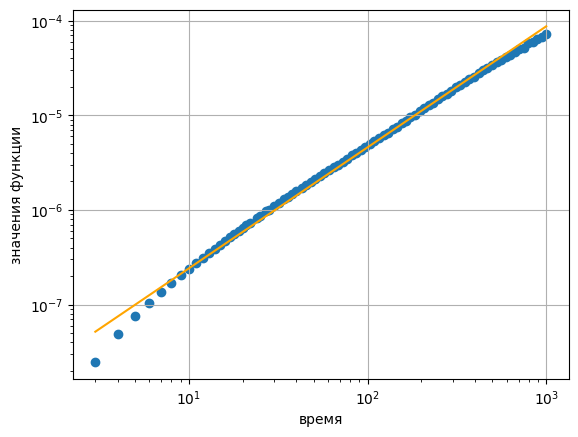

In [ ]:
plt.loglog(10**(tlin), 10**(H_hat*tlin + C_hat), color = "orange")
plt.scatter(lag,dfa)
plt.xlabel("время")
plt.ylabel("значения функции")
plt.grid()
plt.show()